In [180]:
# ==============================================================================
# IMPORTS AND SETUP
# ==============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pytorch_lightning as pl
from torchinfo import summary

# Local imports
from yuriy_preprocess import get_yuriy_data
from cnn_1d_model import CNN1D
from NeuralNetTrainer import NeuralNetTrainer
from training_utils import MetricsLogger, create_data_loaders

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


In [181]:
# ==============================================================================
# DATA LOADING AND PREPROCESSING
# ==============================================================================

# Load and prepare data
print("Loading and preprocessing data...")
X, Y, meta_data = get_yuriy_data(samples_around=300)

# Convert labels to 0-based indexing and encode
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Convert to torch tensors and transpose to (trials, channels, timepoints)
X_tensor = torch.from_numpy(X).float().permute(0, 2, 1)  # (trials, time, channels) -> (trials, channels, time)
Y_tensor = torch.from_numpy(Y_encoded).long()

# Split data into train/test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.2, random_state=42, stratify=Y_tensor
)

# CNN1D expects (batch, channels, time) - NO extra dimension needed unlike ConvLUN
# So we keep X_train and X_test as is without unsqueeze(1)

# Display data info
print(f"Data shape: {X.shape} -> Processed: {X_train.shape}")
print(f"Classes: {np.unique(Y)} -> Encoded: {np.unique(Y_encoded)}")
print(f"Channels: {len(meta_data['channel_names'])}, Sampling freq: {meta_data['sampFreq']} Hz")
print(f"Train/Test split: {X_train.shape[0]}/{X_test.shape[0]} samples")


Loading and preprocessing data...
Data shape: (1388, 600, 19) -> Processed: torch.Size([1110, 19, 600])
Classes: [1 2] -> Encoded: [0 1]
Channels: 19, Sampling freq: 200 Hz
Train/Test split: 1110/278 samples


In [182]:
# ==============================================================================
# MODEL CONFIGURATION
# ==============================================================================

# Model parameters
n_outputs = len(np.unique(Y_encoded))
n_chans = X_tensor.shape[1]  # Number of channels  
n_times = X_tensor.shape[2]  # Number of time samples
sfreq = meta_data['sampFreq']

# Create CNN1D model
model = CNN1D(
    input_channels=n_chans,
    num_samples=n_times,
    sample_freq=sfreq,
    channels=[95, 100, 100, 100, 100],
    kernel_size=10,
    dropout=0.5,
    activation=nn.GELU,
    pooling=nn.AvgPool1d,
    pooling_kernel_size=2,
    num_conv_blocks=3,
)

print(f"Model configured with {n_outputs} classes, {n_chans} channels, {n_times} timepoints")

# Test model with sample input first (to initialize LazyLinear)
sample_input = torch.randn(2, n_chans, n_times)
sample_output = model(sample_input)
print(f"Sample input shape: {sample_input.shape} -> Output shape: {sample_output.shape}")

# Now print the model summary
print("\nModel Summary:")
summary(model, input_size=(2, n_chans, n_times))

Model configured with 2 classes, 19 channels, 600 timepoints
Sample input shape: torch.Size([2, 19, 600]) -> Output shape: torch.Size([2, 2])

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [2, 2]                    --
├─Sequential: 1-1                        [2, 95, 599]              --
│    └─Conv1d: 2-1                       [2, 95, 599]              9,595
│    └─BatchNorm1d: 2-2                  [2, 95, 599]              190
│    └─GELU: 2-3                         [2, 95, 599]              --
│    └─Dropout1d: 2-4                    [2, 95, 599]              --
├─Sequential: 1-2                        [2, 100, 599]             --
│    └─Conv1d: 2-5                       [2, 100, 599]             9,600
│    └─BatchNorm1d: 2-6                  [2, 100, 599]             200
│    └─GELU: 2-7                         [2, 100, 599]             --
│    └─Dropout1d: 2-8                    [2, 100, 599]             --
├─ModuleList: 1-3                        --                        --
│    └─Sequential: 2-9                   [2, 100, 299]             --
│    │ 

In [183]:
# ==============================================================================
# TRAINING EXECUTION
# ==============================================================================

# Setup trainer
nntrainer = NeuralNetTrainer(
    model=model,
    loss_fn=torch.nn.CrossEntropyLoss(),
    learning_rate=0.001,
    metrics={'accuracy': lambda y_hat, y: torch.mean((torch.argmax(y_hat, dim=1) == y).float())},
    scheduler=lr_scheduler.ReduceLROnPlateau,
    scheduler_kwargs={
        'factor': 0.5,
        'patience': 10,
        'min_lr': 1e-6,
    },
)

# Create data loaders
train_loader, val_loader = create_data_loaders(
    X_train, 
    Y_train, 
    batch_size=32, 
    loader_kwargs={'num_workers': 30, 'persistent_workers': True}
)

# Setup metrics logging and trainer
metrics_logger = MetricsLogger(to_log=['accuracy', 'loss'])
trainer = pl.Trainer(
    max_epochs=200, 
    log_every_n_steps=10,
    callbacks=[
        metrics_logger, 
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    ]
)

# Train model
print("Starting training...")
trainer.fit(nntrainer, train_loader, val_loader)
print("Training completed!")


/Users/alejandro/watolink/Models/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 16 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | CNN1D            | 335 K  | train
1 | los

Starting training...
Epoch 104: 100%|██████████| 28/28 [00:00<00:00, 66.66it/s, v_num=83, train_loss_step=0.198, val_loss=0.269, train_loss_epoch=0.0996] 
Training completed!


In [184]:
# ==============================================================================
# MODEL EVALUATION
# ==============================================================================

# Evaluate model performance
print("Evaluating model performance...")

# Training accuracy
model.eval()
with torch.no_grad():
    train_outputs = model(X_train)
    train_preds = torch.argmax(train_outputs, dim=1)
    train_accuracy = torch.mean((train_preds == Y_train).float()).item()

# Test accuracy
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_accuracy = torch.mean((test_preds == Y_test).float()).item()

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Sample predictions
print(f"\nSample predictions (first 10 test samples):")
for i in range(min(10, len(Y_test))):
    pred_class = label_encoder.inverse_transform([test_preds[i].item()])[0]
    actual_class = label_encoder.inverse_transform([Y_test[i].item()])[0]
    status = "✓" if test_preds[i] == Y_test[i] else "✗"
    print(f"{status} Predicted: {pred_class}, Actual: {actual_class}")


Evaluating model performance...
Training Accuracy: 0.9820
Test Accuracy: 0.9137

Sample predictions (first 10 test samples):
✗ Predicted: 1, Actual: 2
✓ Predicted: 1, Actual: 1
✓ Predicted: 1, Actual: 1
✓ Predicted: 2, Actual: 2
✓ Predicted: 2, Actual: 2
✓ Predicted: 2, Actual: 2
✓ Predicted: 1, Actual: 1
✓ Predicted: 2, Actual: 2
✓ Predicted: 1, Actual: 1
✓ Predicted: 2, Actual: 2


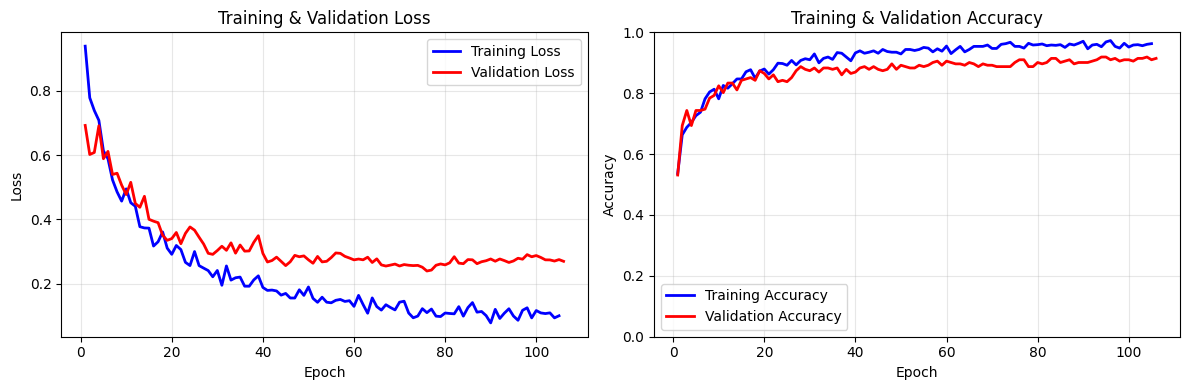

Final Training Loss: 0.0996
Final Validation Loss: 0.2691
Final Training Accuracy: 0.9628
Final Validation Accuracy: 0.9144

FINAL RESULTS SUMMARY
Model: CNN1D
Data shape: torch.Size([1110, 19, 600]) (batch, channels, time)
Classes: 2 ([1 2])
Training samples: 1110
Test samples: 278
Training Accuracy: 0.9820
Test Accuracy: 0.9137


In [185]:
# ==============================================================================
# TRAINING VISUALIZATION
# ==============================================================================

train_losses = metrics_logger.train_metrics['loss']
val_losses = metrics_logger.val_metrics['loss']
train_accuracies = metrics_logger.train_metrics['accuracy']
val_accuracies = metrics_logger.val_metrics['accuracy']

# Plot training curves
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
if train_losses and val_losses:
    # Create separate epoch ranges for train and validation (they might have different lengths)
    train_epochs = range(1, len(train_losses) + 1)
    val_epochs = range(1, len(val_losses) + 1)
    
    plt.plot(train_epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(val_epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 2, 2)
if train_accuracies and val_accuracies:
    # Create separate epoch ranges for train and validation accuracies
    train_acc_epochs = range(1, len(train_accuracies) + 1)
    val_acc_epochs = range(1, len(val_accuracies) + 1)
    
    plt.plot(train_acc_epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(val_acc_epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Display final metrics
if train_losses:
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
if val_losses:
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
if train_accuracies:
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
if val_accuracies:
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Print model summary
print(f"\n{'='*60}")
print(f"FINAL RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Model: CNN1D")
print(f"Data shape: {X_train.shape} (batch, channels, time)")
print(f"Classes: {len(np.unique(Y_encoded))} ({np.unique(Y)})")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"{'='*60}")


In [186]:
# Save the complete model
torch.save(model.state_dict(), 'cnn_1d_model.pth')

print("Model saved successfully!")
print("Files created:")
print("- cnn_1d_model.pth: Model weights and parameters")

Model saved successfully!
Files created:
- cnn_1d_model.pth: Model weights and parameters
